# Redundancy Reduction in Metal Nanoparticle Data Sets via Iterative Archetypal Analysis

**author:** Jonathan Yik Chang Ting

**email:** Jonathan.Ting@anu.edu.au

This is a notebook to reduce the redundancy in metal nanoparticle data sets using the iterative archetypal analysis functionalities provided by *archetypes.py*.

## Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

from os import chdir, getcwd
import pickle
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import cdist
import seaborn as sns
import sklearn
from sklearn.datasets import load_diabetes, make_blobs
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

chdir('/scratch/q27/jt5911/iterative-archetypal-analysis/iaa/docs/')
import iaa
from iaa import ArchetypalAnalysis, fitPIAA, runAA, subsetSplit, createSimplexAx, mapAlfaToSimplex, plotRadarDatapoint, plotTSNE


# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  iaa: {iaa.__version__}")
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  scipy: {scipy.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")

Versions of imported libraries:
  iaa: 0.1.0
  matplotlib: 3.9.1
  numpy: 1.26.4
  pandas: 2.2.2
  scipy: 1.14.0
  seaborn: 0.13.2
  scikit-learn: 1.5.1


In [2]:
# General variables
DATA_DIR = f"{getcwd()}/data"
RANDOM_STATE = 42
VERBOSE = True
NUM_JOBS = 48

# Variables specific for figures plotting
DPI = None
FIG_SIZE = (7, 4)
sns.set_style('ticks')

# Variables specific for splitting data into subsets
SHUFFLE = True  # Whether to shuffle data samples before splitting.

# Variables specific for archetypes.py functionalities
C = 0.0001  # constraint coefficient to ensure that the summation of alpha and beta equals to 1.

# Variables specific for the archetypal analysis algorithm provided by the SPArse Modeling Software (SPAMS) package
ROBUST = False  # Whether to use modified AA algorithm to deal with outliers
TOLERANCE = 0.001  # Threshold to decide when to stop optimisation.
COMPUTE_XTX = False  # Whether to compute X^T * X
STEPS_FISTA = 3  # Number of steps for fast iterative shrinkage-thresholding algorithm
STEPS_AS = 50  # Number of steps for active set algorithm
RANDOM_INIT = False  # Whether to initialise the archetypes randomly

# Directory paths
SUBSETS_PICKLES_PATH = './data/subsetsDataPKLs'
OUTPUTS_PICKLES_PATH = './data/subsetsOutputsPKLs'
FIGS_DIR_PATH = './figs'
JOBSCRIPTS_DIR_PATH = "./jobScripts"
BASH_SCRIPT_PATH = '/scratch/q27/jt5911/iterative-archetypal-analysis/iaa/src/runAAs.sh'

# Set random seed
np.random.seed(RANDOM_STATE)

### Arguments Description
- **n_archetypes**: Defines how many archetypes will be extracted. A positive integer. Setting to 1 return the mean of the data set. *Default = 2*.
- **iterative**: Whether to use the iterative or classical approach. *Default = False*.
- **n_subsets**: The number of subsets to split the data into if **iterative** = True. *Default = 10*.
- **shuffle**: Whether to shuffle the data samples before splitting. *Default = True*.
- **only_archetypes**: Whether to stop running when archetypes are computed. Setting to True allows only archetypes and run time to be returned. *Default = False*.
- **C**: the weight on the constraint equation. Inversely proportional to the strength of constraint. *Default = 0.0001*. Constraint Equation: $$\sum\alpha = 1,$$ $$\sum\beta = 1$$

The following arguments are specific to the archetypal analysis algorithm provided by the [SPArse Modeling Software (SPAMS) package](https://thoth.inrialpes.fr/people/mairal/spams/), hence Users are directed to their homepage and the original publication describing the algorithm in "[Fast and Robust Archetypal Analysis for Representation Learning](https://ieeexplore.ieee.org/document/6909588)" for up-to-date and detailed descriptions.
- **robust**
- **tolerance**
- **computeXtX**
- **stepsFISTA**
- **stepsAS**
- **randominit**
- **random_state**
- **numThreads**

## General Functions

In [3]:
def loadCSV(csvFilePath, isMono=True, molLabels=True, ele='Au', transFrac=True):
    """
    The monometallic dataset has different naming for certain features, hence why 'isMono' needs to be specified.
    """
    featDF = pd.read_csv(csvFilePath, sep=',', header=0)
    

    if isMono:
        featDF = featDF.rename(columns={'N_total': 'N_atom_total', 'N_bulk': 'N_atom_bulk', 'N_surface': 'N_atom_surface', 
                                        'Avg_total': 'TCN_avg', 'Avg_bulk': 'BCN_avg', 'Avg_surf': 'SCN_avg', 
                                        'Avg_bonds': 'BL_avg', 'Std_bonds': 'BL_std', 'Max_bonds': 'BL_max', 'Min_bonds': 'BL_min', 'N_bonds': 'BL_num',
                                        'angle_avg': 'BA1_avg', 'angle_std': 'BA1_std'}, 
                               inplace=False)
        eleSpecificFeats = [feat for feat in featDF.columns if 'CN_' in feat 
                                                            or 'BL_' in feat
                                                            or 'BA1_' in feat]
        # Rename and generate element-specific features to match bimetallic and trimetallic feature names
        eleSpecNewFeatNamesDict = {}
        for feat in eleSpecificFeats:
            eleSpecNewFeatName = f"MMM_{feat}" if 'BA1_' in feat else f"MM_{feat}"
            eleSpecNewFeatNamesDict[feat] = eleSpecNewFeatName
            eleSpecNewFeatName = f"{ele}{ele}{ele}_{feat}" if 'BA1_' in feat else f"{ele}{ele}_{feat}"
            featDF[eleSpecNewFeatName] = featDF[feat]
        featDF = featDF.rename(columns=eleSpecNewFeatNamesDict, inplace=False)
            
        # Rename q6q6 features to match bimetallic and trimetallic q6q6 feature names
        q6q6Feats = [feat for feat in featDF.columns if 'q6q6_T' in feat or 'q6q6_B' in feat or 'q6q6_S' in feat]
        q6q6NewFeatNamesDict = {}
        for feat in q6q6Feats:
            q6q6NewFeatName = f"{feat[:6]}_{feat[6:]}"
            q6q6NewFeatNamesDict[feat] = q6q6NewFeatName
        featDF = featDF.rename(columns=q6q6NewFeatNamesDict, inplace=False)
    
    # Replace count features with percentages
    if transFrac:
        bulkAtomFeats = [feat for feat in featDF.columns if ('BCN' in feat and '_avg' not in feat)
                                                         or ('BGCN' in feat and '_avg' not in feat)
                                                         or ('q6q6_B' in feat and '_avg' not in feat)]
        surfAtomFeats = [feat for feat in featDF.columns if 'N_Au' in feat or 'N_Pd' in feat or 'N_Pt' in feat
                                                         or ('SCN' in feat and '_avg' not in feat)
                                                         or ('SGCN' in feat and '_avg' not in feat)
                                                         or ('SOCN' in feat and '_avg' not in feat)
                                                         or ('SOGCN' in feat and '_avg' not in feat)
                                                         or ('q6q6_S' in feat and '_avg' not in feat)
                                                         or 'Curve' in feat
                                                         or 'S_100' in feat
                                                         or 'S_111' in feat
                                                         or 'S_110' in feat
                                                         or 'S_311' in feat]
        totAtomFeats = [feat for feat in featDF.columns if 'N_Au' in feat or 'N_Pd' in feat or 'N_Pt' in feat
                                                        or ('TCN' in feat and '_avg' not in feat)
                                                        or ('TGCN' in feat and '_avg' not in feat)
                                                        or ('q6q6_T' in feat and '_avg' not in feat)
                                                        or 'FCC' in feat 
                                                        or 'HCP' in feat
                                                        or 'ICOS' in feat
                                                        or 'DECA' in feat]
        numBulkAtomFeat = featDF['N_atom_bulk']
        numSurfAtomFeat = featDF['N_atom_surface']
        numTotalAtomFeat = featDF['N_atom_total']
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for feat in bulkAtomFeats:
                featDF[f"Frac_{feat}"] = featDF[feat] / numBulkAtomFeat
            for feat in surfAtomFeats:
                if 'N_Au' in feat or 'N_Pd' in feat or 'N_Pt' in feat:
                    featDF[f"Frac_{feat}_Surf"] = featDF[feat] / numSurfAtomFeat
                else:
                    featDF[f"Frac_{feat}"] = featDF[feat] / numSurfAtomFeat
            for feat in totAtomFeats:
                featDF[f"Frac_{feat}"] = featDF[feat] / numTotalAtomFeat
        # featDF.drop(bulkAtomFeats, axis=1, inplace=True)
        # featDF.drop(surfAtomFeats, axis=1, inplace=True)
        # featDF.drop(totAtomFeats, axis=1, inplace=True)

    for feat  in featDF.columns.tolist():
        if 'Vol' in feat:  # Turn the units of volumes from cubic angstroms into cubic metres
            featDF[feat] = featDF[feat].apply(lambda x: 1e-30 / x)
        elif 'R_' in feat:  # Turn the units of radii into nanometres
            featDF[feat] = featDF[feat].apply(lambda x: x / 10)
        if feat == 'R_avg':  # Compute average diameter (nm)
            diameterFeat = featDF[feat].rename(feat.replace('R_avg', 'D_avg')) * 2
            featDF = pd.concat([featDF, diameterFeat], axis=1)
    labelFeats = [feat for feat in featDF.columns if 'Surf_defects' in feat or 'Surf_micros' in feat or 'Surf_facets' in feat or '_E' in feat]
    labelDF = featDF[labelFeats]
    featDF.drop(['ID'] + labelFeats, axis=1, inplace=True)
    return featDF, labelDF

In [4]:
def rmNullLowVarFeats(featsDF, rmNull=False, varThresh=0.0, verbose=False):
    if rmNull:
        if verbose:
            print(f"Removing the features with null values...")
            print(f"  Original number of features: {len(featsDF.columns)}")
        featsToDrop = []
        for feat in featsDF.columns:
            if featsDF[feat].isnull().any():
                featsToDrop.append(feat)
        featsDF.drop(featsToDrop, axis=1, inplace=True)
        if verbose:
            print(f"  Total number of features left: {len(featsDF.columns)}\n")
    if verbose:
        print(f"Removing the features with variance below {varThresh:.2f}...")
        print(f"  Original number of features: {len(featsDF.columns)}")
    featsToDrop = []
    for feat in featsDF.columns:
        if featsDF[feat].var() <= varThresh:
            if verbose:
                print(f"    {feat}:    {featsDF[feat].var():.3f}")
            featsToDrop.append(feat)
    featsNoLowVarDF = featsDF.drop(featsToDrop, axis=1, inplace=False)
    if verbose:
        print(f"  Total number of features left: {len(featsNoLowVarDF.columns)}\n")
    return featsNoLowVarDF

In [5]:
def plotAAoutputs(Xscaled, AAreference, AAiterative,
                  plotSubsets=True, figName='',
                  figSize=(7, 4), dpi=300, verbose=False):
    """Plot the data and archetypes from both approaches."""
    Zreference, Ziterative = AAreference.archetypes, AAiterative.archetypes
    # if verbose:
    #     print(f"Archetype set from reference approach:\n{Zreference}")
    #     print(f"Archetype set from iterative approach:\n{Ziterative}")

    sns.set_palette(QUAL_PALETTE)
    plt.figure(figsize=figSize, dpi=dpi)
    if not plotSubsets:
        plt.scatter(Xscaled[:, 0], Xscaled[:, 1], marker='.', s=5) # color='y', 
    else:
        for idxs in AAiterative.subsetsSampleIdxs: 
            plt.scatter(Xscaled[idxs, 0], Xscaled[idxs, 1], marker='.', s=5)
    allSubsetsZs =  np.concatenate(AAiterative.subsetsZs, axis=1)
    plt.plot(Zreference[0, :], Zreference[1, :], 'X', markersize=9, markeredgecolor='k', markeredgewidth=0.8, color='r', alpha=0.5)  # color='m'
    plt.plot(Ziterative[0, :], Ziterative[1, :], 'X', markersize=9, markeredgecolor='k', markeredgewidth=0.8, color='b', alpha=0.5)  # color='c'
    plt.plot(allSubsetsZs[0, :], allSubsetsZs[1, :], 'D', markersize=4, markeredgecolor='k', markeredgewidth=0.6, color='y')  # color='b'
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(linestyle='dotted')
    legendEntries = [f"Data Subset {i+1}" for i in range(len(AAiterative.subsetsSampleIdxs))] if plotSubsets else ['Data']
    legendEntries += [f"Reference Approach Archetypes, ExpVar: {AAreference.explainedVariance_:.3f}", f"Iterative Approach Archetypes, ExpVar: {AAiterative.explainedVariance_:.3f}", 'Archetypes from Split Sets']
    plt.legend(legendEntries, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=False, fontsize='x-small')
    plt.tight_layout()
    plt.savefig(f"{FIGS_DIR_PATH}/{figName}.png")

In [6]:
def runRAA(Xscaled, numArchetypes=4, robust=False, onlyZ=False, randomState=42, verbose=False):
    AAreference = ArchetypalAnalysis(nArchetypes=numArchetypes, iterative=False, robust=robust, onlyZ=onlyZ,
                                     C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                                     randomState=randomState, numThreads=NUM_JOBS)
    AAreference.fit(Xscaled)
    if verbose:
        print(f"Reference archetypal analysis execution time: {AAreference.runTime:.3f} s")
        print(f"Explained variance: {AAreference.explainedVariance_:.3f}\n")
    return AAreference

In [8]:
def runPIAA1(Xscaled, numArchetypes=4, numSubset=4, shuffle=True, randomState=42, 
             datasetType='uniformSquare', numCPUs=48, wallTime='01:00:00', mem=190, verbose=False):
    splitRunTime = subsetSplit(Xscaled, n_subsets=numSubset, dataName=datasetType, subsetsPicklesPath=SUBSETS_PICKLES_PATH,
                               shuffle=shuffle, randomState=randomState, verbose=verbose)
    # Arguments: (i) dataset name, (ii) number of archetypes, (iii) number of CPUs, (iv) walltime, (v) memory (GB)
    !bash {BASH_SCRIPT_PATH} {datasetType} {numArchetypes} {numCPUs} {wallTime} {mem}
    return splitRunTime

In [9]:
def runPIAA2(Xscaled, numArchetypes=4, numSubset=4, onlyZ=False,
             robust=False, shuffle=True, randomState=RANDOM_STATE, 
             datasetType='uniformSquare', verbose=False, splitRunTime=0.0):
    AAiterative = fitPIAA(Xscaled, nArchetypes=numArchetypes, numSubset=numSubset, 
                          dataName=datasetType, outputsPicklesPath=OUTPUTS_PICKLES_PATH, 
                          shuffle=shuffle, robust=robust, onlyZ=onlyZ, C=0.0001, tolerance=TOLERANCE, 
                          computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                          randomState=randomState, numThreads=NUM_JOBS, splitRunTime=splitRunTime, verbose=verbose)
    if verbose:
        print(f"Parallel iterative archetypal analysis {numSubset} subsets execution time: {AAiterative.runTime:.3f} s\n")
    return AAiterative

In [10]:
def runAAonData(Xscaled, AAreference, AAiterative,
                datasetType='uniformSquare', plotSubsets=True, figSize=(7, 4), dpi=300, verbose=False):
    colourSubsetsStr = 'colourSubsets' if plotSubsets else 'colourWholeSet'
    plotAAoutputs(Xscaled, AAreference, AAiterative,
                  plotSubsets=plotSubsets, figName=f"{datasetType}_{numSubset}-fold_{colourSubsetsStr}",
                  figSize=figSize, dpi=dpi, verbose=verbose)

The following functionalities are covered:
- extraction of the archetype attributes, 
- mapping of data to the archetype space,
- visualisation of archetype profiles (contributions of the archetypes in describing any other data sample), 
- identification of the most archetypal data samples, 
- visualisation of the data samples and archetypes on parallel axis.

## Load Data

In [11]:
TRANS_FRAC = False
VAR_THRESH = 0

In [8]:
# # MNPs
# # Gold nanoparticle data set doesn't contain these labels: {Surf_defects_*, Surf_micros_*, Surf_facets_*}
# AuFeatsDF, AuOriLabelsDF = loadCSV('data/Au_nanoparticle_dataset.csv', isMono=True, molLabels=False, ele='Au', transFrac=TRANS_FRAC)  
# PdFeatsDF, PdOriLabelsDF = loadCSV('data/Pd_nanoparticle_dataset.csv', isMono=True, molLabels=True, ele='Pd', transFrac=TRANS_FRAC)
# PtFeatsDF, PtOriLabelsDF = loadCSV('data/Pt_nanoparticle_dataset.csv', isMono=True, molLabels=True, ele='Pt', transFrac=TRANS_FRAC)
# MNPFeatsDF = pd.concat([AuFeatsDF, PdFeatsDF, PtFeatsDF], axis=0)
# MNPFeatsDF = MNPFeatsDF.reset_index(inplace=False)
# MNPFeatsDF = MNPFeatsDF.drop(['index'], axis=1, inplace=False)
# MNPFeatsDF = rmNullLowVarFeats(featsDF=MNPFeatsDF, rmNull=True, varThresh=VAR_THRESH, verbose=VERBOSE)

# del AuOriLabelsDF, PdOriLabelsDF, PtOriLabelsDF

In [9]:
# # BNPs
# AuPdFeats, AuPdOriLabels = loadCSV('data/AuPd_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del AuPdOriLabels
# AuPtFeats, AuPtOriLabels = loadCSV('data/AuPt_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del AuPtOriLabels
# PdAuFeats, PdAuOriLabels = loadCSV('data/PdAu_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del PdAuOriLabels
# PdPtFeats, PdPtOriLabels = loadCSV('data/PdPt_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del PdPtOriLabels
# PtAuFeats, PtAuOriLabels = loadCSV('data/PtAu_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del PtAuOriLabels
# PtPdFeats, PtPdOriLabels = loadCSV('data/PtPd_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del PtPdOriLabels

# # Correction of naming mistakes in BNP data sets
# numCurve1 = AuPdFeats['MM_TCN_avg']
# AuPdFeats['MM_TCN_avg'] = AuPdFeats['Curve_171-180']
# AuPdFeats['Curve_171-180'] = 0
# AuPdFeats['Curve_1-10'] = AuPdFeats['Curve_1-10'] + numCurve1

# numCurve1 = AuPtFeats['MM_TCN_avg']
# AuPtFeats['MM_TCN_avg'] = AuPtFeats['Curve_171-180']
# AuPtFeats['Curve_171-180'] = 0
# AuPtFeats['Curve_1-10'] = AuPtFeats['Curve_1-10'] + numCurve1

# numCurve1 = PdAuFeats['MM_TCN_avg']
# PdAuFeats['MM_TCN_avg'] = PdAuFeats['Curve_171-180']
# PdAuFeats['Curve_171-180'] = 0
# PdAuFeats['Curve_1-10'] = PdAuFeats['Curve_1-10'] + numCurve1

# numCurve1 = PdPtFeats['MM_TCN_avg']
# PdPtFeats['MM_TCN_avg'] = PdPtFeats['Curve_171-180']
# PdPtFeats['Curve_171-180'] = 0
# PdPtFeats['Curve_1-10'] = PdPtFeats['Curve_1-10'] + numCurve1

# numCurve1 = PtAuFeats['MM_TCN_avg']
# PtAuFeats['MM_TCN_avg'] = PtAuFeats['Curve_171-180']
# PtAuFeats['Curve_171-180'] = 0
# PtAuFeats['Curve_1-10'] = PtAuFeats['Curve_1-10'] + numCurve1

# numCurve1 = PtPdFeats['MM_TCN_avg']
# PtPdFeats['MM_TCN_avg'] = PtPdFeats['Curve_171-180']
# PtPdFeats['Curve_171-180'] = 0
# PtPdFeats['Curve_1-10'] = PtPdFeats['Curve_1-10'] + numCurve1

# # Combine datasets with the same elemental combinations
# PdAuFeats.rename({'PdAu_BL_avg': 'AuPd_BL_avg', 'PdAu_BL_max': 'AuPd_BL_max', 'PdAu_BL_min': 'AuPd_BL_min', 'PdAu_BL_num': 'AuPd_BL_num', 
#                   'PdAu_BL_std': 'AuPd_BL_std', 'PdAu_frac': 'AuPd_frac'}, axis=1, inplace=True)
# PdAuFeats[AuPdFeats.columns]
# AuPdFeatsDF = pd.concat([AuPdFeats, PdAuFeats], axis=0)
# del AuPdFeats, PdAuFeats
# AuPdFeatsDF = AuPdFeatsDF.reset_index(inplace=False)
# AuPdFeatsDF.drop(['index'], axis=1, inplace=True)
# # AuPdFeatsDF = AuPdFeatsDF.dropna(axis=1)

# PtAuFeats.rename({'PtAu_BL_avg': 'AuPt_BL_avg', 'PtAu_BL_max': 'AuPt_BL_max', 'PtAu_BL_min': 'AuPt_BL_min', 'PtAu_BL_num': 'AuPt_BL_num', 
#                   'PtAu_BL_std': 'AuPt_BL_std', 'PtAu_frac': 'AuPt_frac'}, axis=1, inplace=True)
# PtAuFeats[AuPtFeats.columns]
# AuPtFeatsDF = pd.concat([AuPtFeats, PtAuFeats], axis=0)
# del AuPtFeats, PtAuFeats
# AuPtFeatsDF = AuPtFeatsDF.reset_index(inplace=False)
# AuPtFeatsDF.drop(['index'], axis=1, inplace=True)
# # AuPtFeatsDF = AuPtFeatsDF.dropna(axis=1)

# PtPdFeats.rename({'PtPd_BL_avg': 'PdPt_BL_avg', 'PtPd_BL_max': 'PdPt_BL_max', 'PtPd_BL_min': 'PdPt_BL_min', 'PtPd_BL_num': 'PdPt_BL_num', 
#                   'PtPd_BL_std': 'PdPt_BL_std', 'PtPd_frac': 'PdPt_frac'}, axis=1, inplace=True)
# PtPdFeats[PdPtFeats.columns]
# PdPtFeatsDF = pd.concat([PdPtFeats, PtPdFeats], axis=0)
# del PdPtFeats, PtPdFeats
# PdPtFeatsDF = PdPtFeatsDF.reset_index(inplace=False)
# PdPtFeatsDF.drop(['index'], axis=1, inplace=True)
# # PdPtFeatsDF = PdPtFeatsDF.dropna(axis=1)

# BNPFeatsDF = pd.concat([AuPdFeatsDF, AuPtFeatsDF, PdPtFeatsDF], axis=0)
# BNPFeatsDF = BNPFeatsDF.reset_index(inplace=False)
# BNPFeatsDF.drop(['index'], axis=1, inplace=True)
# BNPFeatsDF = rmNullLowVarFeats(featsDF=BNPFeatsDF, rmNull=True, varThresh=VAR_THRESH, verbose=VERBOSE)

In [10]:
# # TNPs
# TNPFeatsDF, TNPOriLabelsDF = loadCSV('data/AuPdPt_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# TNPFeatsDF = rmNullLowVarFeats(featsDF=TNPFeatsDF, rmNull=True, varThresh=VAR_THRESH, verbose=VERBOSE)
# del TNPOriLabelsDF

In [11]:
# Storing the features
# with open(f"{DATA_DIR}/MNPFeatsDF.pickle", 'wb') as f:
#     pickle.dump(MNPFeatsDF, f)
# with open(f"{DATA_DIR}/BNPFeatsDF.pickle", 'wb') as f:
#     pickle.dump(BNPFeatsDF, f)
# with open(f"{DATA_DIR}/TNPFeatsDF.pickle", 'wb') as f:
#     pickle.dump(TNPFeatsDF, f)

In [12]:
# Loading data
with open(f"{DATA_DIR}/MNPFeatsDF.pickle", 'rb') as f:
    MNPFeatsDF = pickle.load(f)
# with open(f"{DATA_DIR}/BNPFeatsDF.pickle", 'rb') as f:
#     BNPFeatsDF = pickle.load(f)
# with open(f"{DATA_DIR}/TNPFeatsDF.pickle", 'rb') as f:
#     TNPFeatsDF = pickle.load(f)

## Redundancy Reduction

### MNP

In [13]:
eleComb = 'MNP'

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(MNPFeatsDF)

In [14]:
MNPFeatsDF

,T,tau,time,N_atom_total,N_atom_bulk,N_atom_surface,Volume,R_min,R_max,R_diff,...,q6q6_S_5,q6q6_S_6,q6q6_S_7,q6q6_S_8,q6q6_S_9,q6q6_S_10,q6q6_S_11,q6q6_S_12,q6q6_S_13,D_avg
0,273,0.000025,1,1599,1014,585,0.000037,1.55898,1.94516,0.38618,...,25,18,18,13,18,1,0,0,1,3.47412
1,273,0.000025,2,1642,1034,608,0.000036,1.53996,2.41755,0.87760,...,26,26,6,15,12,2,0,1,0,3.52122
2,273,0.000025,3,4637,3365,1272,0.000013,2.19199,3.10305,0.91106,...,99,117,123,99,116,51,17,1,0,5.07384
3,273,0.000025,4,7189,5292,1897,0.000008,2.32542,3.78795,1.46253,...,147,188,214,227,227,121,64,9,0,5.94022
4,273,0.000025,5,11004,8508,2496,0.000005,2.71200,3.97614,1.26415,...,190,281,308,287,320,156,74,7,1,6.85662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,673,0.000250,6,3303,2078,1225,0.000022,0.93836,3.35346,2.41511,...,76,188,249,188,256,134,79,0,0,4.48412
9296,673,0.000250,7,3690,2364,1326,0.000019,1.02056,3.43654,2.41598,...,105,178,241,229,282,144,67,0,0,4.62978
9297,673,0.000250,8,4099,2663,1436,0.000017,0.98460,3.45833,2.47373,...,104,197,253,226,307,159,76,0,0,4.80190
9298,673,0.000250,9,4482,2914,1568,0.000016,1.07151,3.69595,2.62444,...,118,210,273,214,346,174,76,0,0,4.97370


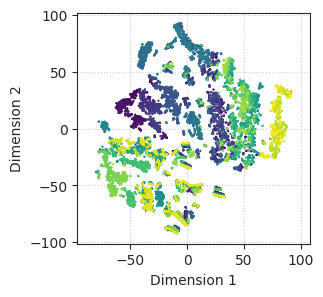

In [15]:
eleComb = 'MNP'

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(MNPFeatsDF)

# Visualise data via t-SNE
# plotTSNE(Xscaled, figNamePrefix=eleComb, perplexity=30, markerSize=0.5, nJobs=NUM_JOBS)

In [68]:
numSubset = 10
allNumArchetypes = range(2, 10)
for numArchetypes in allNumArchetypes:
    # Split the data into subsets and run archetypal analysis on each subset
    splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                            datasetType=f"{DATASET_TYPE}{numSubset}S{numArchetypes}A", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119751288.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata1.pkl
119751289.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata2.pkl
119751290.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata3.pkl
Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119751291.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata1.pkl
119751292.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata2.pkl
119751293.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata3.pkl
Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119751294.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata1.pkl
119751295.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata2.pkl
119751296.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata3.pkl
Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running ar

In [ ]:
# Run iterative archetypal analysis over a range of number of archetypes
numArchetypesRange = range(50, 301, 50)
runTimes, expVars, closestSampleIdxs = [], [], []
for numArchetypes in numArchetypesRange:
    numSubset = 10
    iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                             C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                             random_state=RANDOM_STATE, numThreads=NUM_JOBS)
    iAA.fit(Xscaled)
    iAA._extract_close_match()
    runTimes.append(iAA.run_time)
    expVars.append(iAA.explained_variance_)
    closestSampleIdxs.append([sampleIdx for (sampleIdx, archetype) in iAA.close_match.values()])

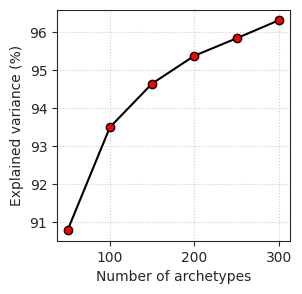

In [58]:
# Elbow plot to decide number of archetypes
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, [expVar*100 for expVar in expVars], 
         color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Explained variance (%)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}expVar.png", bbox_inches='tight')

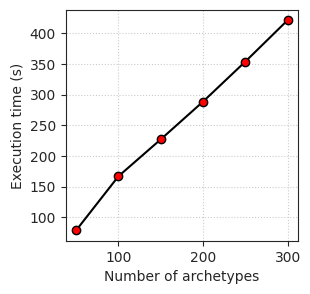

In [59]:
# Growth in execution time as number of archetypes increases
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, runTimes, color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Execution time (s)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}exeTime.png", bbox_inches='tight')

In [ ]:
# Visualise the difference in most archetypal samples as number of archetypes changes
for (i, idxs) in enumerate(closestSampleIdxs):
    plotTSNE(Xscaled, figNamePrefix=f"{eleComb}_{numArchetypesRange[i]}p_iAA", perplexity=30, markerSize=0.5, nJobs=NUM_JOBS, markIdxs=idxs)

In [14]:
# Rerun iterative archetypal analysis with the decided number of archetypes
numArchetypes = 100
numSubset = 10
iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
iAA.fit(Xscaled)
print(f"Iterative archetypal analysis execution time: {iAA.run_time:.3f} s")
print(f"Explained variance: {iAA.explained_variance_:.6f}\n")

RSS FISTA = 32633.975
RSS FISTA = 17399.804
RSS FISTA = 12372.356
RSS AS = 10088.935
RSS AS = 9410.1515
RSS AS = 9031.2131
RSS AS = 8743.4491
RSS AS = 8548.2756
RSS AS = 8414.4749
RSS AS = 8311.4737
RSS AS = 8204.778
RSS AS = 8063.8768
RSS AS = 7915.6745
RSS AS = 7795.9975
RSS AS = 7733.9386
RSS AS = 7699.8514
RSS AS = 7669.8603
RSS AS = 7633.7608
RSS AS = 7592.9593
RSS AS = 7552.0417
RSS AS = 7520.1018
RSS AS = 7499.4314
RSS AS = 7485.8045
RSS AS = 7476.3431
RSS AS = 7469.1955
RSS AS = 7463.4586
RSS AS = 7459.0314
RSS AS = 7455.1432
RSS AS = 7451.5474
RSS AS = 7448.0097
RSS AS = 7444.4511
RSS AS = 7440.6168
RSS AS = 7436.1728
RSS AS = 7430.7111
RSS AS = 7423.6977
RSS AS = 7414.3088
RSS AS = 7402.1777
RSS AS = 7388.5549
RSS AS = 7374.9065
RSS AS = 7361.3719
RSS AS = 7348.7701
RSS AS = 7337.3976
RSS AS = 7326.9583
RSS AS = 7316.6823
RSS AS = 7304.2108
RSS AS = 7288.1281
RSS AS = 7268.9496
RSS AS = 7245.9821
RSS AS = 7230.5067
RSS AS = 7226.4162
RSS AS = 7223.7852
RSS AS = 7221.5322
RSS 

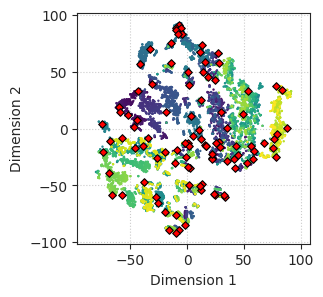

In [29]:
idxs = [3029, 8008, 3908, 4909, 7007, 1017, 8149, 8167, 2808, 5796, 2906, 3786, 4794, 3234, 6027, 4828, 903, 8267, 4795, 3014, 5908, 3973, 4790, 2990, 1128, 7328, 6118, 8604, 972, 2104, 114, 3949, 1791, 3903, 1003, 1782, 4793, 8246, 793, 3799, 7201, 3085, 3553, 1212, 5792, 800, 912, 210, 9191, 48, 795, 8360, 3176, 8290, 367, 3478, 9162, 4306, 7136, 3801, 3427, 4706, 2918, 8698, 769, 7071, 4292, 4491, 4309, 2630, 4458, 521, 4657, 130, 5899, 8820, 1098, 4101, 4484, 7432, 554, 8003, 472, 5474, 7626, 3703, 4545, 591, 6970, 7807, 4573, 4687, 7182, 9180, 7702, 4634, 9075, 864, 9134, 4534]
plotTSNE(Xscaled, figNamePrefix=f"{eleComb}_100p_iAA", perplexity=30, markerSize=0.5, nJobs=NUM_JOBS, markIdxs=idxs)

#### Visualise outputs

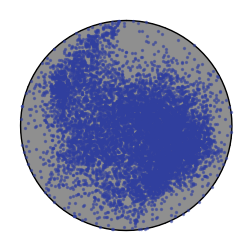

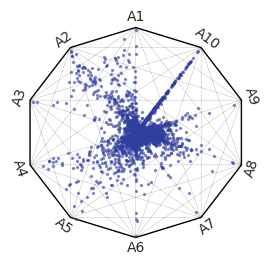

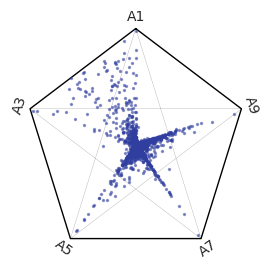

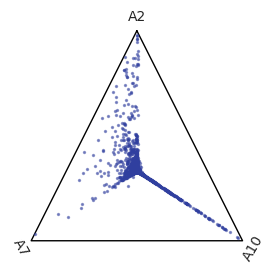

In [15]:
# Map data to restricted (numArchs) archetype spaces
iAA.plot_simplex(iAA.alfa, archIDs=list(range(iAA.n_archetypes)), showLabel=False, figNamePrefix=f"{eleComb}_allAs")  # All archetypes
iAA.plot_simplex(iAA.alfa, archIDs=list(range(10)), showLabel=True, figNamePrefix=f"{eleComb}_10As")
iAA.plot_simplex(iAA.alfa, archIDs=[0, 2, 4, 6, 8], showLabel=True, figNamePrefix=f"{eleComb}_5As")
iAA.plot_simplex(iAA.alfa, archIDs=[1, 6, 9], showLabel=True, figNamePrefix=f"{eleComb}_3As")

In [20]:
# Display all feature names
# print(list(zip([i for i in range(len(allfeatNames))], allfeatNames)))

# Select features of interest
allFeatNames = list(MNPFeatsDF.columns)
selectedFeatsIdxs = [
    0, 1, 2,  # Processing conditions
    3, 4, 5,  # Atom counts
    6, 10,  # Sizes
    14, 15, 16, 17,  #Facets
    18, 19, 20, 21, 22, 23, 24, 25, # 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,  # Curvature
    36, 37, 38,  # Average coordination numbers
    102, 103,  # Bond length statistics
    109, 110, 111, 112,  # Crystal structures
    113, 114, 115,  # Number of bonded neighbours by Steinhardt's parameters
]

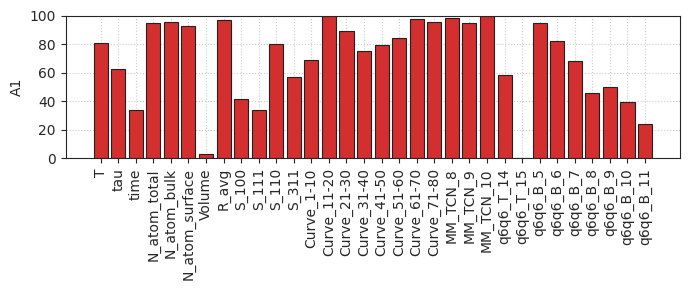

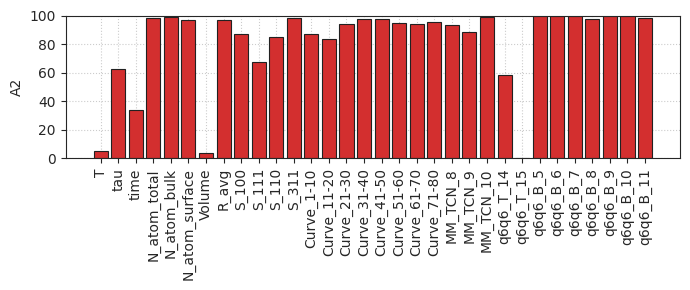

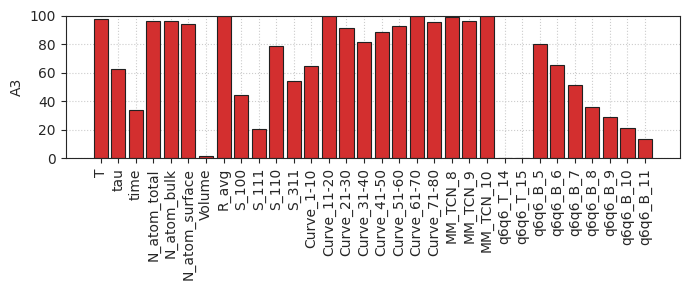

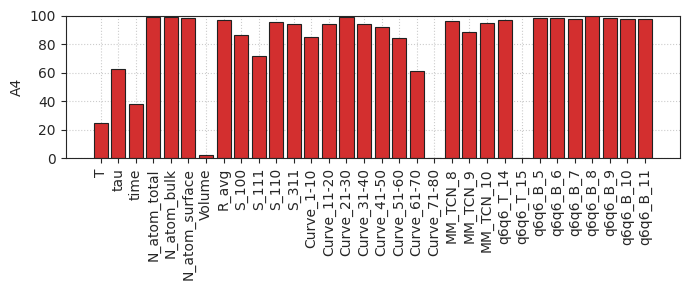

In [61]:
# Visualise archetype profile via bar plots
iAA.plot_profile(allFeatNames, selectedFeatsIdxs, archIDs=list(range(4)), figSize=(7, 3), figNamePrefix=eleComb)

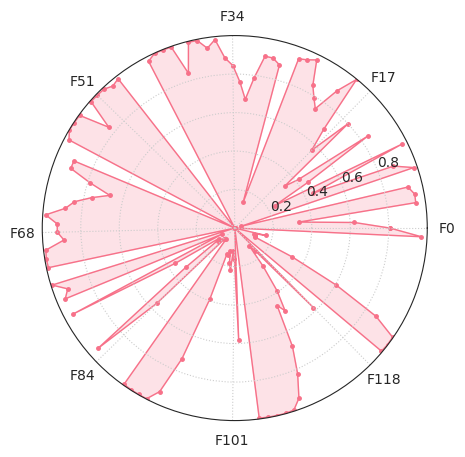

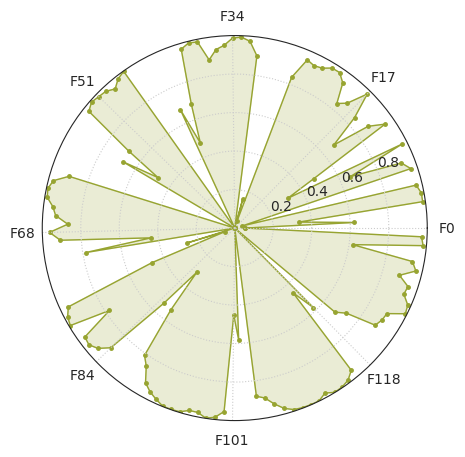

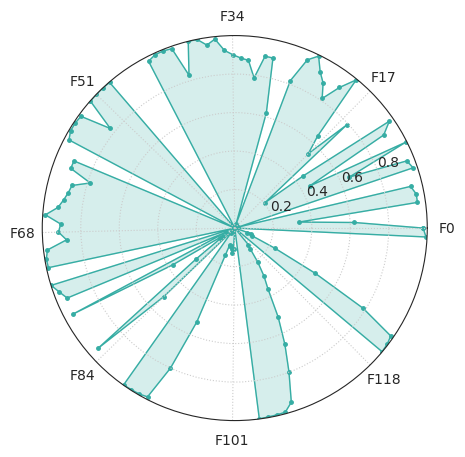

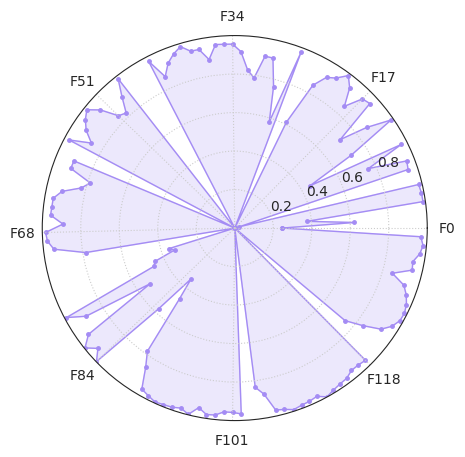

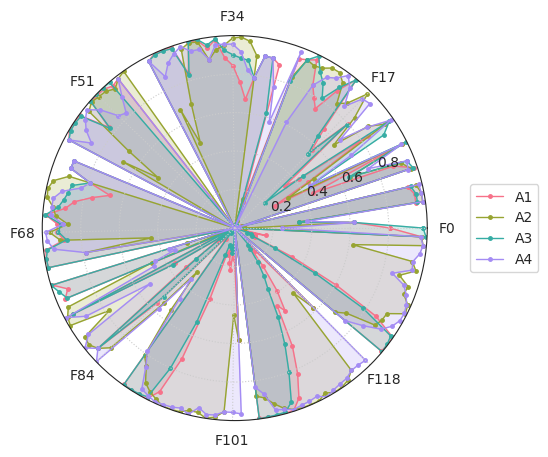

In [71]:
# Visualise archetype profile via radar plot
iAA.plot_radar_profile(allFeatNames, selectedFeatsIdxs=list(range(len(allFeatNames))), archIDs=list(range(4)), 
                       sepArchs=True, showLabel=True, labelAll=False, figSize=(5, 5), figNamePrefix=eleComb)  # Individual
iAA.plot_radar_profile(allFeatNames, selectedFeatsIdxs=list(range(len(allFeatNames))), archIDs=list(range(4)), 
                       sepArchs=False, showLabel=True, labelAll=False, figSize=(5, 5), figNamePrefix=eleComb)  # All in one

In [ ]:
# Visualise samples and archetypes on parallel axis
iAA.parallel_plot(allfeatNames, dfArgs[['color']].copy(), linewidth='0.3', arch_color='k')

### BNP

In [ ]:
eleComb = 'BNP'

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(BNPFeatsDF)

# Visualise data via t-SNE
# plotTSNE(Xscaled, figNamePrefix=eleComb, perplexity=30, markerSize=0.5, nJobs=NUM_JOBS)

In [ ]:
# Run iterative archetypal analysis over a range of number of archetypes
numArchetypesRange = range(1000, 5001, 1000)
runTimes, expVars, closestSampleIdxs = [], [], []
for numArchetypes in numArchetypesRange:
    numSubset = 10
    iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                             C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                             random_state=RANDOM_STATE, numThreads=NUM_JOBS)
    iAA.fit(Xscaled)
    iAA._extract_close_match()
    runTimes.append(iAA.run_time)
    expVars.append(iAA.explained_variance_)
    closestSampleIdxs.append([sampleIdx for (sampleIdx, archetype) in iAA.close_match.values()])

In [ ]:
# Elbow plot to decide number of archetypes
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, [expVar*100 for expVar in expVars], 
         color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Explained variance (%)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}expVar.png", bbox_inches='tight')

In [ ]:
# Growth in execution time as number of archetypes increases
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, runTimes, color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Execution time (s)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}exeTime.png", bbox_inches='tight')

In [69]:
# Rerun iterative archetypal analysis with the decided number of archetypes
numArchetypes = 100
numSubset = 10
iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
iAA.fit(Xscaled)
print(f"Iterative archetypal analysis execution time: {iAA.run_time:.3f} s")
print(f"Explained variance: {iAA.explained_variance_:.6f}\n")

RSS FISTA = 32633.975
RSS FISTA = 17399.804
RSS FISTA = 12372.356
RSS AS = 10088.935
RSS AS = 9410.1515
RSS AS = 9031.2131
RSS AS = 8743.4491
RSS AS = 8548.2756
RSS AS = 8414.4749
RSS AS = 8311.4737
RSS AS = 8204.778
RSS AS = 8063.8768
RSS AS = 7915.6745
RSS AS = 7795.9975
RSS AS = 7733.9386
RSS AS = 7699.8514
RSS AS = 7669.8603
RSS AS = 7633.7608
RSS AS = 7592.9593
RSS AS = 7552.0417
RSS AS = 7520.1018
RSS AS = 7499.4314
RSS AS = 7485.8045
RSS AS = 7476.3431
RSS AS = 7469.1955
RSS AS = 7463.4586
RSS AS = 7459.0314
RSS AS = 7455.1432
RSS AS = 7451.5474
RSS AS = 7448.0097
RSS AS = 7444.4511
RSS AS = 7440.6168
RSS AS = 7436.1728
RSS AS = 7430.7111
RSS AS = 7423.6977
RSS AS = 7414.3088
RSS AS = 7402.1777
RSS AS = 7388.5549
RSS AS = 7374.9065
RSS AS = 7361.3719
RSS AS = 7348.7701
RSS AS = 7337.3976
RSS AS = 7326.9583
RSS AS = 7316.6823
RSS AS = 7304.2108
RSS AS = 7288.1281
RSS AS = 7268.9496
RSS AS = 7245.9821
RSS AS = 7230.5067
RSS AS = 7226.4162
RSS AS = 7223.7852
RSS AS = 7221.5322
RSS 

In [30]:
# Visualise the difference in most archetypal samples as number of archetypes changes
for (i, idxs) in enumerate(closestSampleIdxs):
    plotTSNE(Xscaled, figNamePrefix=f"{eleComb}_{numArchetypesRange[i]}p_iAA", perplexity=30, markerSize=0.5, nJobs=NUM_JOBS, markIdxs=idxs)

[3029, 8008, 3908, 4909, 7007, 1017, 8149, 8167, 2808, 5796, 2906, 3786, 4794, 3234, 6027, 4828, 903, 8267, 4795, 3014, 5908, 3973, 4790, 2990, 1128, 7328, 6118, 8604, 972, 2104, 114, 3949, 1791, 3903, 1003, 1782, 4793, 8246, 793, 3799, 7201, 3085, 3553, 1212, 5792, 800, 912, 210, 9191, 48, 795, 8360, 3176, 8290, 367, 3478, 9162, 4306, 7136, 3801, 3427, 4706, 2918, 8698, 769, 7071, 4292, 4491, 4309, 2630, 4458, 521, 4657, 130, 5899, 8820, 1098, 4101, 4484, 7432, 554, 8003, 472, 5474, 7626, 3703, 4545, 591, 6970, 7807, 4573, 4687, 7182, 9180, 7702, 4634, 9075, 864, 9134, 4534]


### TNP

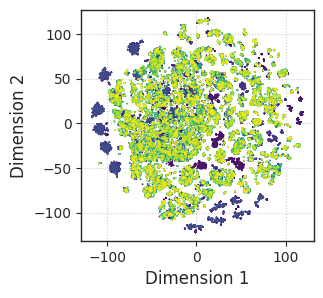

In [188]:
eleComb = 'TNP'

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(TNPFeatsDF)

# Visualise data via t-SNE
plotTSNE(Xscaled, figNamePrefix=eleComb, perplexity=30, markerSize=0.5, nJobs=NUM_JOBS)

In [ ]:
# Run iterative archetypal analysis over a range of number of archetypes
numArchetypesRange = range(100, 501, 100)
runTimes, expVars, closestSampleIdxs = [], [], []
for numArchetypes in numArchetypesRange:
    numSubset = 10
    iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                             C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                             random_state=RANDOM_STATE, numThreads=NUM_JOBS)
    iAA.fit(Xscaled)
    iAA._extract_close_match()
    runTimes.append(iAA.run_time)
    expVars.append(iAA.explained_variance_)
    closestSampleIdxs.append([sampleIdx for (sampleIdx, archetype) in iAA.close_match.values()])

RSS FISTA = 2406467.2
RSS FISTA = 1765975.7
RSS FISTA = 1583605.1
RSS AS = 1440796.1
RSS AS = 1399038.6
RSS AS = 1375280.8
RSS AS = 1361035
RSS AS = 1346651.4
RSS AS = 1330412.8
RSS AS = 1316070.4
RSS AS = 1310505.4
RSS AS = 1307551.7
RSS AS = 1305409.9
RSS AS = 1303808.2
RSS AS = 1302554.8
RSS AS = 1301491.7
RSS AS = 1300575.1
RSS AS = 1299789
RSS AS = 1299081.2
RSS AS = 1298464.5
RSS AS = 1297889.9
RSS AS = 1297344.4
RSS AS = 1296830.4
RSS AS = 1296344.2
RSS AS = 1295871.5
RSS AS = 1295393.1
RSS AS = 1294884.3
RSS AS = 1294291.1
RSS AS = 1293461.4
RSS AS = 1291755.9
RSS AS = 1286075.4
RSS AS = 1273531.5
RSS AS = 1270879.6
RSS AS = 1269407.3
RSS AS = 1268072.8
RSS AS = 1266908.6
RSS AS = 1266000.3
RSS AS = 1265413.1
RSS AS = 1265038
RSS AS = 1264768.7
RSS AS = 1264543.7
RSS AS = 1264340
RSS AS = 1264144.2
RSS AS = 1263953.5
RSS AS = 1263787
RSS AS = 1263631.6
RSS AS = 1263488.4
RSS AS = 1263351.8
RSS AS = 1263207.9
RSS AS = 1263044.6
RSS AS = 1262856.5
RSS AS = 1262646.3
RSS AS = 1262

In [ ]:
# Elbow plot to decide number of archetypes
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, [expVar*100 for expVar in expVars], 
         color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Explained variance (%)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}expVar.png", bbox_inches='tight')

In [ ]:
# Growth in execution time as number of archetypes increases
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, runTimes, color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Execution time (s)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}exeTime.png", bbox_inches='tight')

In [69]:
# Rerun iterative archetypal analysis with the decided number of archetypes
numArchetypes = 100
numSubset = 10
iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
iAA.fit(Xscaled)
print(f"Iterative archetypal analysis execution time: {iAA.run_time:.3f} s")
print(f"Explained variance: {iAA.explained_variance_:.6f}\n")

RSS FISTA = 32633.975
RSS FISTA = 17399.804
RSS FISTA = 12372.356
RSS AS = 10088.935
RSS AS = 9410.1515
RSS AS = 9031.2131
RSS AS = 8743.4491
RSS AS = 8548.2756
RSS AS = 8414.4749
RSS AS = 8311.4737
RSS AS = 8204.778
RSS AS = 8063.8768
RSS AS = 7915.6745
RSS AS = 7795.9975
RSS AS = 7733.9386
RSS AS = 7699.8514
RSS AS = 7669.8603
RSS AS = 7633.7608
RSS AS = 7592.9593
RSS AS = 7552.0417
RSS AS = 7520.1018
RSS AS = 7499.4314
RSS AS = 7485.8045
RSS AS = 7476.3431
RSS AS = 7469.1955
RSS AS = 7463.4586
RSS AS = 7459.0314
RSS AS = 7455.1432
RSS AS = 7451.5474
RSS AS = 7448.0097
RSS AS = 7444.4511
RSS AS = 7440.6168
RSS AS = 7436.1728
RSS AS = 7430.7111
RSS AS = 7423.6977
RSS AS = 7414.3088
RSS AS = 7402.1777
RSS AS = 7388.5549
RSS AS = 7374.9065
RSS AS = 7361.3719
RSS AS = 7348.7701
RSS AS = 7337.3976
RSS AS = 7326.9583
RSS AS = 7316.6823
RSS AS = 7304.2108
RSS AS = 7288.1281
RSS AS = 7268.9496
RSS AS = 7245.9821
RSS AS = 7230.5067
RSS AS = 7226.4162
RSS AS = 7223.7852
RSS AS = 7221.5322
RSS 

In [30]:
# Visualise the difference in most archetypal samples as number of archetypes changes
for (i, idxs) in enumerate(closestSampleIdxs):
    plotTSNE(Xscaled, figNamePrefix=f"{eleComb}_{numArchetypesRange[i]}p_iAA", perplexity=30, markerSize=0.5, nJobs=NUM_JOBS, markIdxs=idxs)

[3029, 8008, 3908, 4909, 7007, 1017, 8149, 8167, 2808, 5796, 2906, 3786, 4794, 3234, 6027, 4828, 903, 8267, 4795, 3014, 5908, 3973, 4790, 2990, 1128, 7328, 6118, 8604, 972, 2104, 114, 3949, 1791, 3903, 1003, 1782, 4793, 8246, 793, 3799, 7201, 3085, 3553, 1212, 5792, 800, 912, 210, 9191, 48, 795, 8360, 3176, 8290, 367, 3478, 9162, 4306, 7136, 3801, 3427, 4706, 2918, 8698, 769, 7071, 4292, 4491, 4309, 2630, 4458, 521, 4657, 130, 5899, 8820, 1098, 4101, 4484, 7432, 554, 8003, 472, 5474, 7626, 3703, 4545, 591, 6970, 7807, 4573, 4687, 7182, 9180, 7702, 4634, 9075, 864, 9134, 4534]
